In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Deep Learning\\Lab 7\\Deep-Learning-Model-Customization-and-Performance-Evaluation\\Research\\Cifar10'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Deep Learning\\Lab 7\\Deep-Learning-Model-Customization-and-Performance-Evaluation'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
print(Path(os.getcwd()))

D:\Desktop\Deep Learning\Lab 7\Deep-Learning-Model-Customization-and-Performance-Evaluation


In [12]:
import logging
import os
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from joblib import dump
from sklearn.preprocessing import LabelEncoder

@dataclass
class DataTransformationConfig:
    root_dir: Path
    X_train_file: Path
    y_train_file: Path
    X_test_file: Path
    y_test_file: Path
    label_encoder_file: Path  # Added this line


class ConfigurationManager:
    def __init__(self):
        self.root_dir = Path(os.getcwd())
        self.X_train_file = self.root_dir / "Dataset/Modeltraining/Cifar10/X_train.npy"
        self.y_train_file = self.root_dir / "Dataset/Modeltraining/Cifar10/y_train.npy"
        self.X_test_file = self.root_dir / "Dataset/Modeltraining/Cifar10/X_test.npy"
        self.y_test_file = self.root_dir / "Dataset/Modeltraining/Cifar10/y_test.npy"
        self.experiment_results_dir = self.root_dir / "ModelExperiments/Cifar10"
        self.label_encoder_file = self.experiment_results_dir / "label_encoder.pkl"  # Adjusted path

    def get_data_transformation_config(self) -> DataTransformationConfig:
        return DataTransformationConfig(
            root_dir=self.root_dir,
            X_train_file=self.X_train_file,
            y_train_file=self.y_train_file,
            X_test_file=self.X_test_file,
            y_test_file=self.y_test_file,
            label_encoder_file=self.label_encoder_file
        )

class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def ensure_directories_exist(self):
        """Ensure that directories for all file paths exist."""
        for path in [self.config.X_train_file, self.config.y_train_file, self.config.X_test_file, self.config.y_test_file]:
            path.parent.mkdir(parents=True, exist_ok=True)

    def encode_labels(self, y_train, y_test):
        # Convert one-hot encoded labels to 1D format
        y_train_1d = np.argmax(y_train, axis=1)
        y_test_1d = np.argmax(y_test, axis=1)
        
        # Convert y_train and y_test to label encoded format
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train_1d)
        y_test_encoded = label_encoder.transform(y_test_1d)
        
        # Save the label encoder for later use
        dump(label_encoder, self.config.label_encoder_file)
        logging.info(f"Label Encoder saved to {self.config.label_encoder_file}")
        
        return y_train_encoded, y_test_encoded
        
        return y_train_encoded, y_test_encoded
            
    def ensure_uniform_class_distribution(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        min_count = np.min(counts)
        avg_count = np.mean(counts)
    
        # Logging the details about class distributions
        logging.info(f"Number of unique classes in y: {len(unique)}")
        logging.info(f"Unique classes in y: {unique}")
        logging.info(f"Counts of each class in y: {counts}")
        logging.info(f"Average frequency of all classes: {avg_count}")
        logging.info(f"Minimum frequency among classes: {min_count}")
    
        X_list = []
        y_list = []
        for class_value in unique:
            class_indices = np.where(y == class_value)[0]
            np.random.shuffle(class_indices)
            selected_indices = class_indices[:min_count]
            X_list.append(X[selected_indices, :])
            y_list.append(y[selected_indices])
    
            # Logging details about data removal for balancing
            logging.info(f"Class {class_value} reduced to {min_count} instances for balancing.")
    
        X_balanced = np.concatenate(X_list, axis=0)
        y_balanced = np.concatenate(y_list, axis=0)
    
        # Shuffling the data to mix the classes
        indices = np.arange(X_balanced.shape[0])
        np.random.shuffle(indices)
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
    
        # Logging final dataset size after balancing
        logging.info(f"Number of rows in the balanced dataset: {X_balanced.shape[0]}")
    
        return X_balanced, y_balanced

    def train_test_splitting(self):

        self.ensure_directories_exist()
        
        # Ensure the directory for the status file exists
        self.config.root_dir.mkdir(parents=True, exist_ok=True)  # This line ensures that the root directory exists

        # Load and preprocess CIFAR-10 dataset
        logging.info("Loading and preprocessing CIFAR-10 dataset...")
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        X_train, X_test = X_train / 255.0, X_test / 255.0
        y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

        # Call the function to encode labels
        y_train_encoded, y_test_encoded = self.encode_labels(y_train, y_test)

        # Combine X_train and X_test to create X
        X = np.concatenate((X_train, X_test), axis=0)
        
        # Combine y_train and y_test to create y
        y = np.concatenate((y_train_encoded, y_test_encoded), axis=0)

        # Normalize pixel values to be between 0 and 1
        # X = X / 255.0

        # Ensure uniform class distribution
        X_balanced, y_balanced = self.ensure_uniform_class_distribution(X, y)

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

        # Save the split data as numpy files
        np.save(self.config.X_train_file, X_train)
        logging.info(f"X_train data saved to {self.config.X_train_file}")
        np.save(self.config.y_train_file, y_train)
        logging.info(f"y_train data saved to {self.config.y_train_file}")
        np.save(self.config.X_test_file, X_test)
        logging.info(f"X_test data saved to {self.config.X_test_file}")
        np.save(self.config.y_test_file, y_test)
        logging.info(f"y_test data saved to {self.config.y_test_file}")

def main():
    config_manager = ConfigurationManager()
    data_transformation_config = config_manager.get_data_transformation_config()
    data_transformation = DataTransformation(data_transformation_config)
    data_transformation.train_test_splitting()

if __name__ == "__main__":
    main()


2024-04-08 17:56:34 - INFO - Loading and preprocessing CIFAR-10 dataset...
2024-04-08 17:56:35 - INFO - Label Encoder saved to D:\Desktop\Deep Learning\Lab 7\Deep-Learning-Model-Customization-and-Performance-Evaluation\ModelExperiments\Cifar10\label_encoder.pkl
2024-04-08 17:56:36 - INFO - Number of unique classes in y: 10
2024-04-08 17:56:36 - INFO - Unique classes in y: [0 1 2 3 4 5 6 7 8 9]
2024-04-08 17:56:36 - INFO - Counts of each class in y: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
2024-04-08 17:56:36 - INFO - Average frequency of all classes: 6000.0
2024-04-08 17:56:36 - INFO - Minimum frequency among classes: 6000
2024-04-08 17:56:36 - INFO - Class 0 reduced to 6000 instances for balancing.
2024-04-08 17:56:36 - INFO - Class 1 reduced to 6000 instances for balancing.
2024-04-08 17:56:36 - INFO - Class 2 reduced to 6000 instances for balancing.
2024-04-08 17:56:36 - INFO - Class 3 reduced to 6000 instances for balancing.
2024-04-08 17:56:36 - INFO - Class 4 reduced t

In [13]:
import pandas as pd
import numpy as np

# Specify the path to your numpy array file
npy_file_path = 'Dataset/Modeltraining/Cifar10/X_train.npy'

# Load the numpy array file
data = np.load(npy_file_path)

# Reshape the 4D array into a 2D array
num_images = data.shape[0]
num_pixels = data.shape[1] * data.shape[2] * data.shape[3]
data_reshaped = data.reshape(num_images, num_pixels)

# Convert the 2D array to a DataFrame
df = pd.DataFrame(data_reshaped)

# Display the DataFrame
df

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.670588,0.678431,0.635294,0.678431,0.686275,0.643137,0.709804,0.717647,0.674510,0.741176,...,0.505882,0.439216,0.431373,0.380392,0.435294,0.423529,0.376471,0.349020,0.333333,0.298039
1,0.443137,0.298039,0.019608,0.396078,0.298039,0.047059,0.270588,0.227451,0.050980,0.176471,...,0.078431,0.113725,0.113725,0.031373,0.098039,0.070588,0.011765,0.101961,0.070588,0.023529
2,0.745098,0.650980,0.552941,0.709804,0.611765,0.529412,0.701961,0.600000,0.529412,0.725490,...,0.631373,0.941176,0.745098,0.713725,0.882353,0.694118,0.698039,0.854902,0.654902,0.658824
3,0.800000,0.819608,0.552941,0.811765,0.819608,0.541176,0.827451,0.815686,0.541176,0.831373,...,0.254902,0.627451,0.533333,0.325490,0.658824,0.576471,0.349020,0.623529,0.517647,0.290196
4,0.070588,0.223529,0.047059,0.090196,0.282353,0.054902,0.101961,0.298039,0.062745,0.094118,...,0.188235,0.392157,0.403922,0.141176,0.337255,0.364706,0.121569,0.352941,0.400000,0.184314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0.580392,0.615686,0.619608,0.533333,0.556863,0.552941,0.596078,0.592157,0.611765,0.611765,...,0.529412,0.443137,0.611765,0.560784,0.537255,0.682353,0.662745,0.490196,0.619608,0.584314
47996,0.137255,0.223529,0.121569,0.180392,0.231373,0.141176,0.090196,0.125490,0.043137,0.258824,...,0.309804,0.345098,0.498039,0.368627,0.207843,0.337255,0.196078,0.294118,0.392157,0.247059
47997,0.737255,0.776471,0.843137,0.721569,0.772549,0.835294,0.721569,0.784314,0.843137,0.721569,...,0.329412,0.631373,0.533333,0.301961,0.603922,0.513725,0.274510,0.619608,0.537255,0.286275
47998,0.839216,0.784314,0.713725,0.803922,0.745098,0.698039,0.796078,0.737255,0.686275,0.827451,...,0.709804,0.890196,0.803922,0.725490,0.905882,0.819608,0.745098,0.894118,0.811765,0.733333


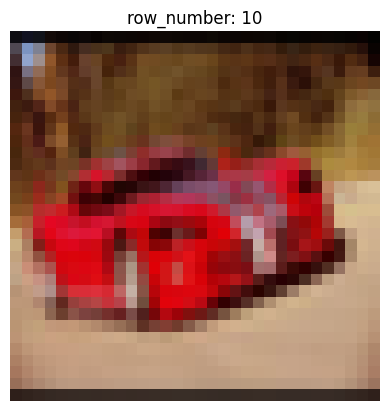

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Specify the path to your numpy array file
npy_file_path = 'Dataset/Modeltraining/Cifar10/X_train.npy'

# Load the numpy array file
data = np.load(npy_file_path)

# Reshape the 4D array into a 2D array
num_images = data.shape[0]
num_pixels = data.shape[1] * data.shape[2] * data.shape[3]
data_reshaped = data.reshape(num_images, num_pixels)

# Convert the 2D array to a DataFrame
df = pd.DataFrame(data_reshaped)

# Select a random row number (change this as per your requirement)
row_number = 10

# Inverse transform the scaled row to get the original image
original_image = df.iloc[row_number].values.reshape(32, 32, 3)

# Display the image
plt.imshow(original_image, cmap="gray")
plt.title(f"row_number: {row_number}")  # Display the row number as the label
plt.axis('off')
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Specify the path to your numpy array file
npy_file_path = 'Dataset/Modeltraining/Cifar10/y_train.npy'

# Load the numpy array file
data = np.load(npy_file_path)

df = pd.DataFrame(data)

# Display the DataFrame
df.head()


,0
0,3
1,3
2,8
3,7
4,8
